In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback , ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from tensorflow.keras.optimizers import (
    SGD,          # Stochastic Gradient Descent
    RMSprop,      # Root Mean Square Propagation
    Adam,         # Adaptive Moment Estimation
    AdamW,        # Adam with Weight Decay
    Nadam,        # Nesterov-accelerated Adam
    Adagrad,      # Adaptive Gradient Algorithm
    Adadelta,     # Adaptive Delta
    Ftrl          # Follow-the-Regularized-Leader
)
import nbformat

In [38]:
# Load data from the file
my_file = "./pentilfuran.MDE"
df = pd.read_csv(my_file, delim_whitespace=True, comment='#', names=["Step", "T", "E_KS", "E_tot", "Vol", "P"])

# Filter and concatenate data based on 'Step'

#VARIANTA 1
# df_data = pd.DataFrame()
# for i in range(1, 100):
#     df1 = df[df['Step'] == i].reset_index(drop=True)
#     df_data = pd.concat([df_data, df1[1:901]], ignore_index=True)

#VARIANTA 2
# Versiunea optimizată - RAPIDĂ
dfs = [df[df['Step'] == i].iloc[1:901] for i in range(1, 100)]
df_data = pd.concat(dfs, ignore_index=True)

print(len(df_data))
en = df_data['E_tot']
step =df_data.index[0:len(df_data['Step'])]

print(len(en))

#? Convert the extracted data into a DataFrame for processing
data = pd.DataFrame({
    'Step': step.values,
    'Energy': en.values
})

#? Preprocessing or converting data in (0,1) interval
scaler = MinMaxScaler()
data['Energy_scaled'] = scaler.fit_transform(data[['Energy']])
len(data)

89100
89100


/tmp/ipykernel_23825/1408320212.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



89100

In [58]:
import time

# Testează codul vechi
start_time = time.time()
df_data_old = pd.DataFrame()
for i in range(1, 100):
    df1 = df[df['Step'] == i].reset_index(drop=True)
    df_data_old = pd.concat([df_data_old, df1[1:901]], ignore_index=True)
old_time = time.time() - start_time

# Testează codul nou
start_time = time.time()
dfs = [df[df['Step'] == i].iloc[1:901] for i in range(1, 100)]
df_data_new = pd.concat(dfs, ignore_index=True)
new_time = time.time() - start_time

print(f"Codul vechi: {old_time:.2f} secunde")
print(f"Codul nou: {new_time:.2f} secunde")
print(f"Speedup: {old_time/new_time:.1f}x mai rapid")

Codul vechi: 0.03 secunde
Codul nou: 0.02 secunde
Speedup: 2.1x mai rapid


In [41]:
# Function to create time-series sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:(i + 100)]
        target = data[(i + 100):(i + 200)] #? the target is the second half of the data
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

#! Define sequence length (important parameter)
sequence_length = 200
OUT_STEPS = 100  # Number of future steps to predict
num_features = 1

sequences, targets = create_sequences(data['Energy_scaled'].values, sequence_length)
print(sequences.shape,targets.shape)

(88900, 100) (88900, 100)


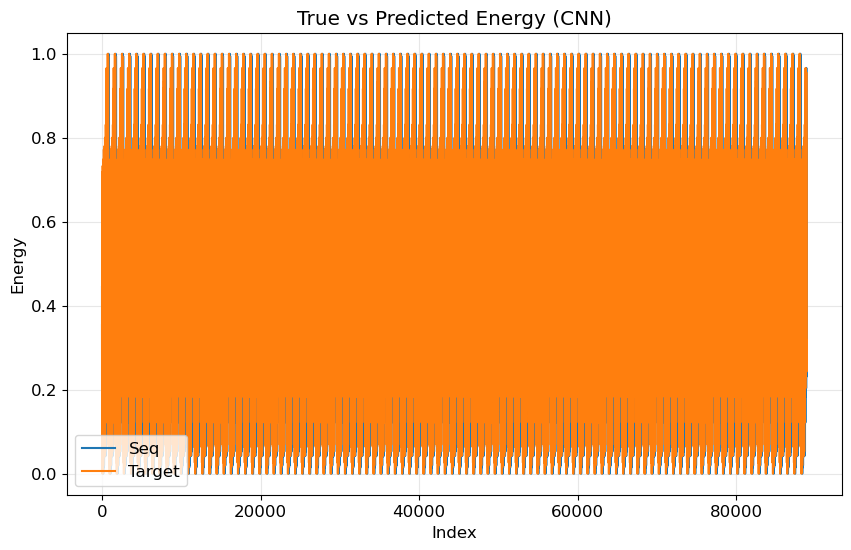

In [42]:
import matplotlib.pyplot as plt

# Creează figura și axele
plt.figure(figsize=(10, 6))

# Plotează secvențele
plt.plot(sequences[:, 1], label='Seq', linewidth=1.5)

# Plotează țintele
plt.plot(targets[:, 1], label='Target', linewidth=1.5)

# Titlu și etichete axe
plt.title('True vs Predicted Energy (CNN)')
plt.xlabel('Index')
plt.ylabel('Energy')

# Legenda
plt.legend()

# Grid
plt.grid(alpha=0.3)

# Afișează graficul
plt.show()


In [43]:
X_train, y_train = sequences[:67000], targets[:67000]
X_val, y_val = sequences[67000:87000], targets[67000:87000]
X_test, y_test = sequences[87000:], targets[87000:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print(" Shape X train test val",X_train.shape,X_test.shape, X_val.shape)
print(" Shape Y train test val",y_train.shape,y_test.shape, y_val.shape)

 Shape X train test val (67000, 100, 1) (1900, 100, 1) (20000, 100, 1)
 Shape Y train test val (67000, 100) (1900, 100) (20000, 100)


In [49]:
def create_improved_hybrid_model(sequence_length, num_features, output_steps):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sequence_length, num_features)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, 
                                                          dropout=0.1, recurrent_dropout=0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)),
        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        
        tf.keras.layers.Dense(output_steps * num_features),
        tf.keras.layers.Reshape([output_steps, num_features])
    ])
    return model


In [50]:
# Define the Multi-Step CNN Model
CONV_WIDTH = 3
# multi_conv_model = tf.keras.Sequential([
#     tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),  # Take the last CONV_WIDTH time steps
#     tf.keras.layers.Conv1D(256, activation='relu', kernel_size=CONV_WIDTH),  # Conv1D layer
#     tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

#VARIANTA 2

# model_hybrid = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, num_features)),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.LSTM(128, activation='relu'),
#     tf.keras.layers.Dense(OUT_STEPS * num_features),
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

model_hybrid = create_improved_hybrid_model(sequence_length, num_features, OUT_STEPS)
# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath="best_autoencoder_model.keras",
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# # Compile and Fit function
# def compile_and_fit(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=10):
#     model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse')
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),callbacks=[early_stopping, model_checkpoint])
#     return history

# # Train the model
# history = compile_and_fit(model_hybrid, X_train, y_train, X_val, y_val, epochs=10, batch_size=10)

# test_loss = model_hybrid.evaluate(X_val, y_val)
# print(f'Test Loss: {test_loss}')

def compile_and_fit_improved(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=32):
    # Optimizer mai bun
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.0005,  # Learning rate mai mic
        weight_decay=0.01
    )
    
    model.compile(
        optimizer=optimizer,
        loss='huber',  # Mai robust decât MSE
        metrics=['mae']
    )
    
    # Callbacks îmbunătățite
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6, verbose=1),
        ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size,  # Batch size mai mare
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    return history





60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
(1900, 100, 1) (1900, 100, 1) (1900, 100)
(190000, 1) (190000, 1)


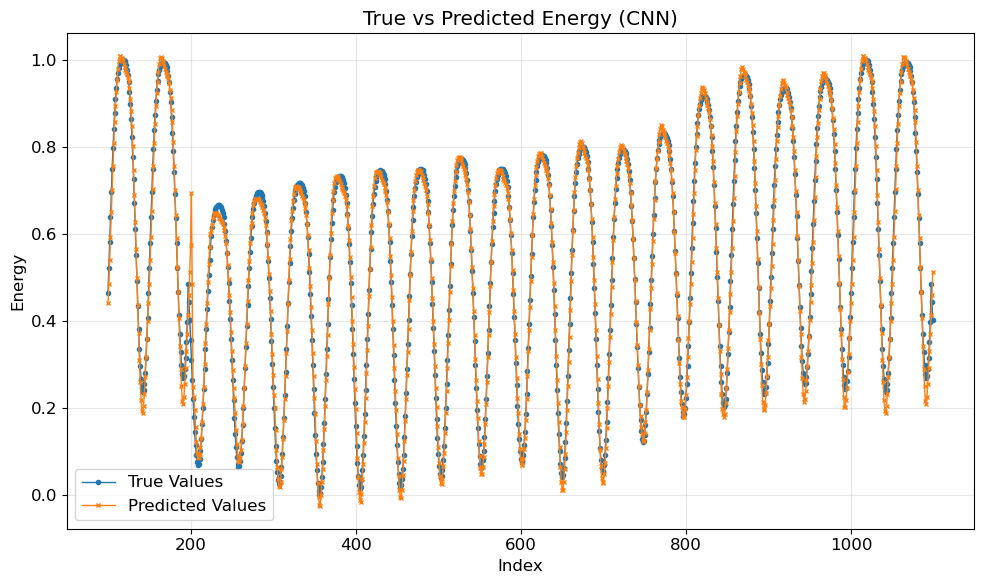

In [51]:
# predictions = multi_conv_model.predict(X_test)
# print(predictions.shape,X_test.shape,y_test.shape)
# # Invert scaling for predictions and actual values
# y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
# predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
# print(predictions_inverted.shape,y_test_inverted.shape)

import matplotlib.pyplot as plt

# Predicții
predictions = multi_conv_model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scalare
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Plot pentru intervalul specificat (100:1100)
start, end = 100, 1100
plt.figure(figsize=(10, 6))

plt.plot(range(start, end), y_test[start:end, 3], label='True Values', marker='o', markersize=3, linewidth=1)
plt.plot(range(start, end), predictions[start:end, 3, 0], label='Predicted Values', marker='x', markersize=3, linewidth=1)

plt.title('True vs Predicted Energy (CNN)')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
(1900, 100, 1) (1900, 100, 1) (1900, 100)
(190000, 1) (190000, 1)


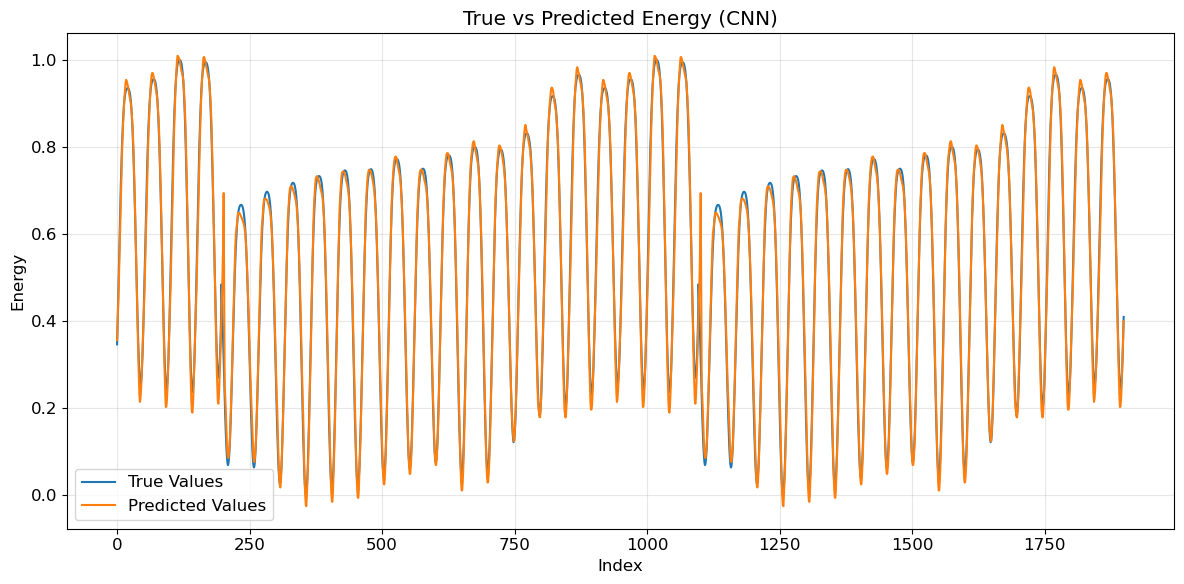

In [52]:
import matplotlib.pyplot as plt

# Predicții
predictions = multi_conv_model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scalare (opțional pentru comparație în valori originale)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Plot pentru toate valorile
plt.figure(figsize=(12, 6))

plt.plot(y_test[:, 3], label='True Values', linewidth=1.5)
plt.plot(predictions[:, 3, 0], label='Predicted Values', linewidth=1.5)

plt.title('True vs Predicted Energy (CNN)')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
(1900, 100, 1) (1900, 100, 1) (1900, 100)
(190000, 1) (190000, 1)


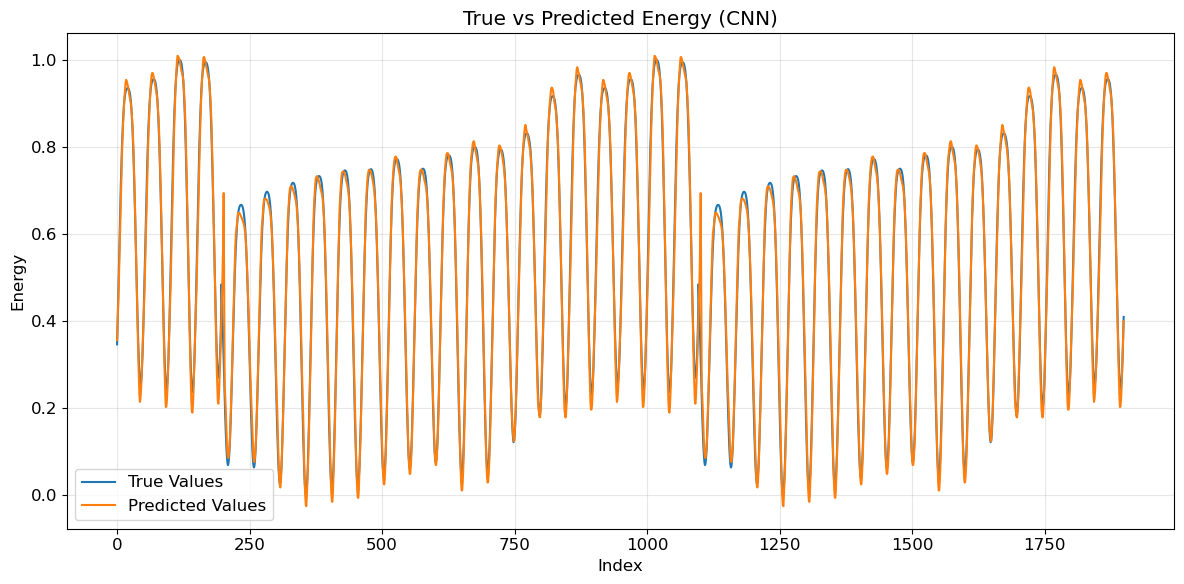

In [53]:
# Predicții
predictions = multi_conv_model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scalare (opțional)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Plot pentru valorile originale (normalizate)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 3], label='True Values', linewidth=1.5)
plt.plot(predictions[:, 3, 0], label='Predicted Values', linewidth=1.5)

plt.title('True vs Predicted Energy (CNN)')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
(1900, 100, 1) (1900, 100, 1) (1900, 100)
(190000, 1) (190000, 1)


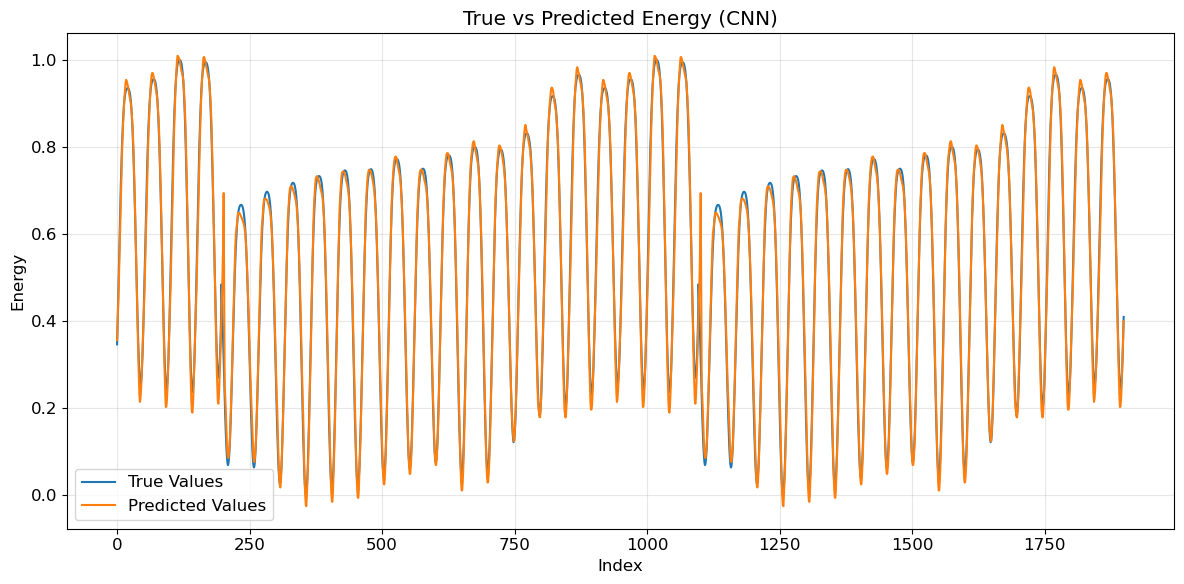

In [54]:

# Predicții
predictions = multi_conv_model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scalare (dacă vrei valori reale)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Plot pentru valorile normalizate (cum e în codul original)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 3], label='True Values', linewidth=1.5)
plt.plot(predictions[:, 3, 0], label='Predicted Values', linewidth=1.5)

plt.title('True vs Predicted Energy (CNN)')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# Setări pentru grafice
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [56]:
def evaluate_model_simple(model, X_test, y_test, scaler):
    """
    Evaluare simplă și clară pentru time series
    """
    # Predicții
    predictions = model.predict(X_test)
    print(f"Forma predicțiilor: {predictions.shape}")
    
    # Inversează scaling-ul
    y_test_flat = y_test.reshape(-1, 1)
    predictions_flat = predictions.reshape(-1, 1)
    
    y_real = scaler.inverse_transform(y_test_flat)
    y_pred = scaler.inverse_transform(predictions_flat)
    
    return y_real, y_pred

# Rulează evaluarea
y_real, y_pred = evaluate_model_simple(multi_conv_model, X_test, y_test, scaler)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
Forma predicțiilor: (1900, 100, 1)


In [57]:
# Calculează R² pentru time series
r2 = r2_score(y_real, y_pred)

print("=" * 50)
print("🎯 ACURATEȚEA MODELULUI TĂU")
print("=" * 50)
print(f"R² Score: {r2:.4f}")
print(f"Acuratețea: {r2*100:.2f}%")
print()

# Interpretarea
if r2 > 0.95:
    print("🟢 EXCELENT! Modelul tău e foarte bun!")
    print("   Predicțiile sunt foarte apropiate de realitate")
elif r2 > 0.85:
    print("🟡 BUN! Modelul funcționează bine")
    print("   Predicțiile sunt în general corecte")
elif r2 > 0.70:
    print("🟠 ACCEPTABIL. Modelul are potențial")
    print("   Poate fi îmbunătățit")
else:
    print("🔴 SLAB. Modelul are nevoie de îmbunătățiri")
    print("   Încearcă alte arhitecturi sau mai multe date")

print(f"\nCe înseamnă R² = {r2:.3f}:")
print(f"Modelul explică {r2*100:.1f}% din variația energiei")
print(f"Restul de {(1-r2)*100:.1f}% rămâne neexplicat")

🎯 ACURATEȚEA MODELULUI TĂU
R² Score: 0.8035
Acuratețea: 80.35%

🟠 ACCEPTABIL. Modelul are potențial
   Poate fi îmbunătățit

Ce înseamnă R² = 0.803:
Modelul explică 80.3% din variația energiei
Restul de 19.7% rămâne neexplicat
